In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt
#from datetime import date #may need

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

#EC added
#from sqlalchemy import create_engine
#from sqlalchemy import Column, Integer, String, Float
#from sqlalchemy.ext.declarative import declarative_base
#Base = declarative_base()

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
#Base.metadata.create_all(engine)

In [6]:
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'measurements', 'station', 'stations']

In [7]:
from sqlalchemy.orm import Session
session = Session(bind=engine)

In [8]:
#station = session.query(Stations)
#for stations in station:
#    print(station.station)

In [9]:
# Get a list of column names and types 'measurement'
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])
# columns

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [10]:
engine.execute('SELECT * FROM measurement LIMIT 5').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0)]

In [11]:
# Get a list of column names and types 'station'
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])
# columns

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [12]:
engine.execute('SELECT * FROM station LIMIT 5').fetchall()

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6)]

In [16]:
# reflect an existing database into a new model
# reflect the tables
# We can view all of the classes that automap found
# Save references to each table

Base = automap_base()
Base.prepare(engine, reflect=True)
Measurement = Base.classes.measurement
Station = Base.classes.station
Base.classes.keys()



['measurement', 'measurements', 'station', 'stations']

In [17]:
# Create our session (link) from Python to the DB

session = Session(engine)

# Exploratory Climate Analysis

In [52]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

last_date=session.query(Measurement.date).order_by(Measurement.date.desc()).first()
#last_date #2017-08-23

# Calculate the date 1 year ago from the last data point in the database
year_ago = dt.date(2017, 8, 23)-dt.timedelta(days=365)
#year_ago #2016-08-23

# Perform a query to retrieve the data and precipitation scores
sel=[Measurement.date, Measurement.prcp]
results=session.query(*sel).filter(Measurement.date>=year_ago).all()
#results

# Save the query results as a Pandas DataFrame and set the index to the date column
df=pd.DataFrame(results)#,index=df.['date'])
df

#df_1=df.set_index('date')
#df_1

# Sort the dataframe by date ###ERROR

#df=df_1.sort_index()
#df

# Use Pandas Plotting with Matplotlib to plot the data
df_2 = pd.DataFrame(results[:10], columns=['date', 'prcp',])
df_2.set_index('date', inplace=True, )
df_2.head(10)

d


,prcp
date,
2016-08-23,0.00
2016-08-24,0.08
2016-08-25,0.08
2016-08-26,0.00
2016-08-27,0.00
2016-08-28,0.01
2016-08-29,0.00
2016-08-30,0.00
2016-08-31,0.13


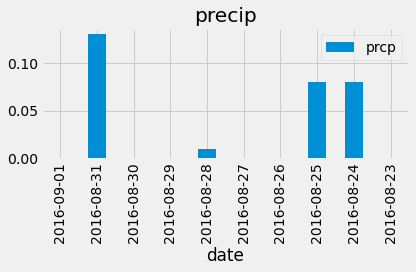

In [55]:
df_2.iloc[::-1].plot.bar(title='precip')
plt.tight_layout()
plt.show()

NameError: name 'date' is not defined

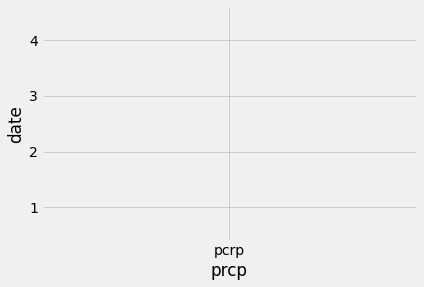

In [46]:
fig, ax = plt.subplots()
ypos = range(1, len("date")+1)
ax.barh(ypos, "prcp"[::-1])
ax.set_xlabel("prcp")
ax.set_ylabel("date")
ax.set_yticks(ypos)
ax.set_yticklabels(date[::-1])
ax.set_title("Emoji Scores")
fig.tight_layout()
plt.show()

In [ ]:
df.iloc[::-1].plot.barh(title="emoji ranking")
plt.tight_layout()
plt.show()

In [56]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [68]:
# Design a query to show how many stations are available in this dataset?
station_count=session.query(func.count(Station.station)).all()
station_count

[(9)]

In [72]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_stations=session.query(Measurement.station, func.count(Measurement.date))\
                              .group_by(Measurement.station)\
                              .order_by(func.count(Measurement.date).desc()).all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [83]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
most_active=active_stations[0][0]
#most_active

sel=[func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)]

results=session.query(*sel).filter(Measurement.station==most_active).all()
results

[(54.0, 85.0, 71.66378066378067)]

In [ ]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram


## Bonus Challenge Assignment

In [ ]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
